In [1]:
import time
from datetime import datetime

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, SimpleRNN, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError as MSELoss
from tensorflow.keras.metrics import MeanAbsolutePercentageError as MAPEMetrics
from tensorflow.keras.metrics import MeanAbsoluteError as MAEMetrics
from tensorflow.keras.metrics import MeanSquaredError as MSEMetrics
from tensorflow.keras.metrics import R2Score

In [2]:
df = pd.read_csv('student_dataset/pppm_20201492_20201334_20201502.csv', header=None, names=['date', 'pollution'])

print(df.head(), '\n', df.tail())

               date  pollution
0  2024-11-19 14:19        0.2
1               NaN        NaN
2  2024-11-19 14:19        0.2
3               NaN        NaN
4  2024-11-19 14:19        0.2 
                   date  pollution
7916  2024-11-19 15:25        4.6
7917               NaN        NaN
7918  2024-11-19 15:25        4.6
7919               NaN        NaN
7920  2024-11-19 15:25        4.3


In [3]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
print(df.head())

                     pollution
date                          
2024-11-19 14:19:00        0.2
NaT                        NaN
2024-11-19 14:19:00        0.2
NaT                        NaN
2024-11-19 14:19:00        0.2


<Axes: title={'center': 'Pollution Over Time'}, xlabel='date'>

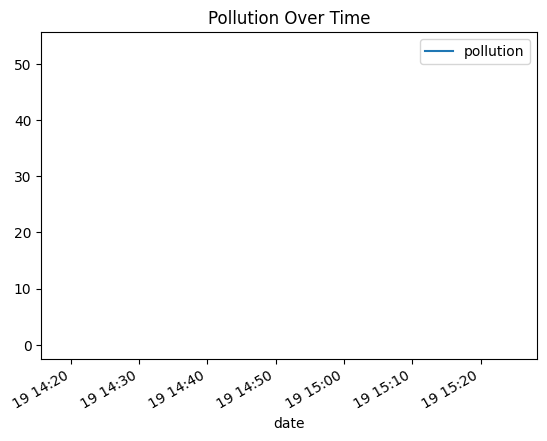

In [4]:
df.plot(y='pollution', kind='line', title='Pollution Over Time')

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7921 entries, 2024-11-19 14:19:00 to 2024-11-19 15:25:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  3961 non-null   float64
dtypes: float64(1)
memory usage: 123.8 KB
None


In [6]:
print(df.describe())

         pollution
count  3961.000000
mean      4.833906
std       3.241614
min       0.200000
25%       3.900000
50%       4.300000
75%       4.600000
max      53.000000


In [7]:
df.dropna(inplace=True)

In [8]:
zScore = StandardScaler()
np_normed = zScore.fit_transform(df)

In [ ]:
minmax = MinMaxScaler()
np_normed = minmax.fit_transform(df)

In [9]:
df_normed = pd.DataFrame(np_normed, columns = ['pollution'])

In [10]:
print(df_normed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3961 entries, 0 to 3960
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  3961 non-null   float64
dtypes: float64(1)
memory usage: 31.1 KB
None


In [11]:
print(df_normed.describe())

          pollution
count  3.961000e+03
mean  -2.870155e-17
std    1.000126e+00
min   -1.429686e+00
25%   -2.881353e-01
50%   -1.647244e-01
75%   -7.216625e-02
max    1.486055e+01


<Axes: title={'center': 'Pollution Over Time'}>

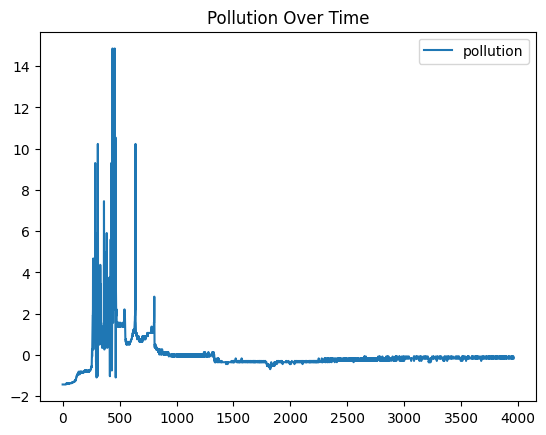

In [12]:
df_normed.plot(y='pollution', kind='line', title='Pollution Over Time')

In [ ]:
val_length = 0.2
lr = 1e-3
labels_length = 30
seq_length = 15


data_features = 1
batch_size = 128
epochs = 1000

In [14]:
train_size = int((len(df_normed) - labels_length) * (1 - val_length))
val_size = int((len(df_normed) - labels_length) - train_size)
print('\nData length: ', len(df_normed), '\nTrain data size: ', train_size, '\nVal data size: ', val_size)

df_train = pd.DataFrame(df_normed.iloc[0:train_size, :])
df_valid = pd.DataFrame(df_normed.iloc[train_size:train_size+val_size, :])
df_test = pd.DataFrame(df_normed.iloc[train_size+val_size:, :])

print('\nData length: ', len(df_train), '\nData head: ', df_train.head(), '\nData tail: ', df_train.tail())
print('\nData length: ', len(df_valid), '\nData head: ', df_valid.head(), '\nData tail: ', df_valid.tail())


Data length:  3961 
Train data size:  3144 
Val data size:  787

Data length:  3144 
Data head:     pollution
0  -1.429686
1  -1.429686
2  -1.429686
3  -1.429686
4  -1.429686 
Data tail:        pollution
3139  -0.164724
3140  -0.164724
3141  -0.164724
3142  -0.164724
3143  -0.164724

Data length:  787 
Data head:        pollution
3144  -0.164724
3145  -0.072166
3146  -0.164724
3147  -0.164724
3148  -0.072166 
Data tail:        pollution
3926  -0.164724
3927  -0.164724
3928  -0.164724
3929  -0.164724
3930  -0.164724


In [15]:
def create_dataset (X, y, look_back = 1):
    Xs, ys = [], []
 
    for i in range(0,len(X)-look_back):
        v = X[i:i+look_back]
        w = y[i+look_back]
        Xs.append(v)
        ys.append(w)
 
    return np.array(Xs), np.array(ys)

In [16]:
np_train = df_train.to_numpy()
np_valid = df_valid.to_numpy()
np_test = df_test.to_numpy()

X_train, y_train = create_dataset(np_train,np_train, seq_length)
X_valid, y_valid = create_dataset(np_valid,np_valid, seq_length)
X_test, y_test = create_dataset(np_test,np_test, seq_length)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(3129, 15, 1)
(3129, 1)
(772, 15, 1)
(772, 1)


In [ ]:
def create_model(units):
    model = Sequential()
    model.add(Input(shape=(seq_length, data_features)))
    model.add(LSTM(units = units*2, return_sequences=True))
    model.add(LSTM(units = units*5, return_sequences=True))
    model.add(LSTM(units = 1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='mse',
                  metrics=[MAEMetrics(), MSEMetrics(), MAPEMetrics(), tf.nn.log_poisson_loss, R2Score])
    return model

lstm_model_build = create_model(seq_length)

I0000 00:00:1732534248.008691 2331033 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22196 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1732534248.009312 2331033 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22196 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:2b:00.0, compute capability: 8.6
I0000 00:00:1732534248.009806 2331033 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22181 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:61:00.0, compute capability: 8.6
I0000 00:00:1732534248.010277 2331033 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22196 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:62:00.0, compute capability: 8.6
I0000 00:00:1732534248.010740 2331033 gpu_device.cc:2022

In [ ]:
lstm_model_build.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 15, 30)         │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 15, 75)         │        31,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1)              │           308 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,948 (140.42 KB)

 Trainable params: 35,948 (140.42 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
checkpoint_path = 'model_store/11c_best_model.weights.h5'

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop_callback = EarlyStopping(monitor='loss', min_delta=0.000001, patience=20)
hist_callback = tf.keras.callbacks.History()
reduceLR_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.005, patience=10, verbose=1, min_delta=0.000001)

In [21]:
def fit_model(model):
    history = model.fit(X_train, y_train, epochs=epochs,  
                        validation_data=(X_valid, y_valid),
                        batch_size=batch_size, shuffle=True,
                        callbacks=[cp_callback, hist_callback, earlystop_callback, reduceLR_callback])
#                         callbacks=[cp_callback, hist_callback, reduceLR_callback])
    return history

In [ ]:
start_time = time.time()
st_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('Start time: ', datetime.now())

train_history = fit_model(lstm_model_build)

print('Start time: ', st_time, '\nFinished time: ', datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
print('Overall training time: ', (time.time()-start_time)/3600, ' hours')

Start time:  2024-11-25 20:30:48.942477
Epoch 1/1000


I0000 00:00:1732534250.663587 2340286 cuda_dnn.cc:529] Loaded cuDNN version 90300


23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - log_poisson_loss: 0.9103 - loss: 0.9464 - mean_absolute_error: 0.4392 - mean_absolute_percentage_error: 82.4640 - mean_squared_error: 0.9464 - r2_score: 0.1480
Epoch 1: val_loss improved from inf to 0.00952, saving model to model_store/11c_best_model.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - log_poisson_loss: 0.9023 - loss: 0.9449 - mean_absolute_error: 0.4307 - mean_absolute_percentage_error: 81.1421 - mean_squared_error: 0.9449 - r2_score: 0.1602 - val_log_poisson_loss: 0.7495 - val_loss: 0.0095 - val_mean_absolute_error: 0.0898 - val_mean_absolute_percentage_error: 76.4675 - val_mean_squared_error: 0.0095 - val_r2_score: -3.2843 - learning_rate: 0.0010
Epoch 2/1000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - log_poisson_loss: 0.7374 - loss: 0.9565 - mean_absolute_error: 0.2931 - mean_absolute_percentage_error: 82.9154 - mean_squared_error: 0.9565 - r2_score: 0.3573
Epoch 2: val_loss improved from 0.00952 to 0.00485, saving model to mo

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


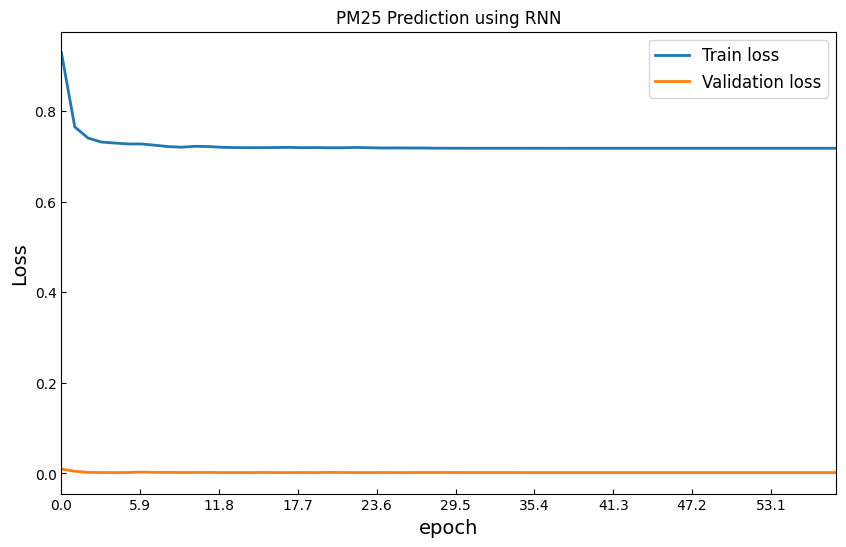

In [ ]:
def plot_loss (history):
    fig, ax= plt.subplots(figsize = (10, 6))
    ax.set_xlim(0, len(history.history['loss'])-1)
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.xaxis.set_major_locator(MultipleLocator(0.1*len(history.history['loss'])))
    
    plt.plot(history.history['loss'],linewidth=2)
    plt.plot(history.history['val_loss'],linewidth=2)
    csfont = {'fontname':'Times New Roman'}
    plt.title('PM25 Prediction using RNN')
    plt.ylabel('Loss',fontsize=14,**csfont)
    plt.xlabel('epoch',fontsize=14,**csfont)
    plt.legend(['Train loss', 'Validation loss'], loc='upper right',fontsize=12)

plot_loss(train_history)

In [24]:
model_build.load_weights(checkpoint_path)

In [25]:
prediction_result = model_build.predict(X_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


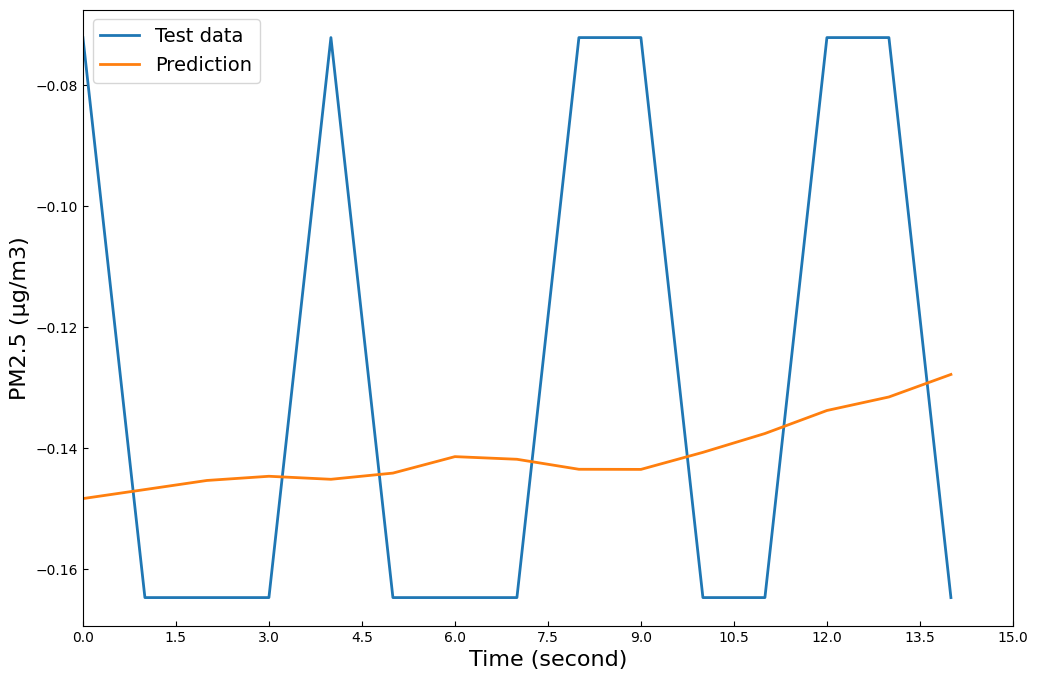

In [26]:
def plot_future(prediction, y_test):
    fig, ax= plt.subplots(figsize = (12, 8))
    ax.set_xlim(0, y_test.shape[0])
    ax.tick_params(axis="y",direction="in")
    ax.tick_params(axis="x",direction="in")
    ax.xaxis.set_major_locator(MultipleLocator(0.1*y_test.shape[0]))
    csfont = {'fontname':'Times New Roman'}
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test),  label='Test data',linewidth=2)
    plt.plot(np.arange(range_future),np.array(prediction),label='Prediction',linewidth=2)
    plt.legend(loc='upper left',fontsize=14)
    plt.xlabel('Time (second)',fontsize=16,**csfont)
    plt.ylabel('PM2.5 (µg/m3)',fontsize=16,**csfont)
    
plot_future(prediction_result, y_test)